### Import modules

In [4]:
import os
import pickle

from os.path import isdir, join
from pathlib import Path

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.utils import to_categorical

from sklearn.model_selection import KFold, train_test_split

In [5]:
tf.test.is_gpu_available()

True

In [6]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Check the location of WAV files

In [7]:
!ls ../audio/wavs

S02_Almost-All-Colleges.wav	     S19_Military-Personnel-Are.wav
S02_A-Monstrous-Shadow.wav	     S19_Nothing-Has-Been.wav
S02_An-Adult-Male.wav		     S19_Of-Course-Dear.wav
S02_Any-Organism-That.wav	     S19_Only-The-Most.wav
S02_Are-You-Looking.wav		     S19_Pam-Gives-Driving.wav
S02_Before-Thursdays-Exam.wav	     S19_Ralph-Prepared-Red.wav
S02_Carl-Lives-In.wav		     S19_She-Had-Your.wav
S02_Combine-All-The.wav		     S19_Steve-Collects-Rare.wav
S02_Continental-Drift-Is.wav	     S19_The-Moisture-In.wav
S02_Did-Shawn-Catch.wav		     S19_The-Small-Boy.wav
S02_Dont-Ask-Me.wav		     S19_The-Surplus-Shoes.wav
S02_Gently-Place-Jims.wav	     S19_The-Tooth-Fairy.wav
S02_George-And-Tom.wav		     S19_They-All-Like.wav
S02_Gregory-And-Tom.wav		     S19_They-Enjoy-It.wav
S02_He-Ate-Four.wav		     S19_They-Were-Already.wav
S02_He-Shrugged-Casually.wav	     S19_Those-Answers-Will.wav
S02_How-Oily-Do.wav		     S19_Thus-Technical-Efficiency.wav
S02_How-Permanent-Are.wav	     S19_Too-Much-Curiosity.wav

### Check wav files

In [8]:
audio_path = '../audio/wavs/'
print(os.listdir(audio_path)[:10])

['S09_He-Ate-Four.wav', 'S26_Those-Answers-Will.wav', 'S28_Try-To-Recall.wav', 'S03_Thus-Technical-Efficiency.wav', 'S25_Try-To-Recall.wav', 'S02_A-Monstrous-Shadow.wav', 'S21_A-Monstrous-Shadow.wav', 'S04_The-Small-Boy.wav', 'S28_Gently-Place-Jims.wav', 'S21_Military-Personnel-Are.wav']


### Extract mel-spectrogram and mfcc features

In [9]:
wav2idx = {}
melspec_dict = {}
mfcc_dict = {}

wav_names = [wav for wav in os.listdir(audio_path) if wav.endswith("wav")]

samples = 132300
max_len = 0

for i, w in enumerate(wav_names):
    wav2idx[w] = i
    wav_path = audio_path + w
    
    y, sr = librosa.load(wav_path) 
    
#     sample = sr * 5
    
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)

    if len(y) > samples: # long enough
        y = y[0:0+samples]

    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    
    
    mel_data = librosa.feature.melspectrogram(y = y, sr= sr)
    mfcc_data = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13)
    mfcc_delta = librosa.feature.delta(mfcc_data)
    mfcc_delta2 = librosa.feature.delta(mfcc_data, order = 2)

    mfcc = np.vstack((mfcc_data, mfcc_delta, mfcc_delta2))
#     if (np.shape(mel_data)[1] > max_len):
#         max_len = np.shape(mel_data)[1] 
    
    melspec_dict[i] = mel_data
    mfcc_dict[i] = mfcc

### Check the shape

In [10]:
print(max_len)
print(sr * 5)
for i in list(melspec_dict.keys())[:10]:
    print(melspec_dict[i].shape)

0
110250
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)


In [11]:
with open("../data/fluency_data.csv", "r") as f:
    data = f.readlines()

In [14]:
X = []
Y = []
X_wav = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)
    
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = mfcc_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(Y))

(11100, 39, 259)
(11100,)


In [17]:
kf = KFold(n_splits = 10)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [29]:
# reshape
X = np.array(X)
X_wav = np.array(X_wav)
print(np.shape(X))
print(np.shape(X_wav))

(11100, 39, 259)
(11100,)


In [30]:
for train_index, test_index in kf.split(X):
    print("TRAIN: ", X_wav[train_index])
    # print("TEST: ", X[test_index])

TRAIN:  [299  55 356 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 497 577 529]
TRAIN:  [400 363 111 ... 580 130 340]


In [19]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_mel = np.shape(X)[1]
max_time = np.shape(X)[2]

In [20]:
input_shape = (num_mel, max_time)

model = Sequential()

model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_mel, max_time)))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(drop_out_rate))
model.add(Dense(num_dense_unit))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model.compile(optimizer=adam, loss="mse", metrics=["mse"])

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 39, 1024)          3162112   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,753,089
T

In [32]:
from datetime import datetime
logdir = "logs/scalars/CV" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [24]:
CV_mse = []
CV_histories = []
CV_prediction = []

In [ ]:
num_epochs = 40

cv_idx = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    X_train_wav, X_test_wav = X_wav[train_index], X_wav[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False,
                       class_weight = None, verbose = 1, validation_data = (X_test, y_test), 
                       callbacks = [tensorboard_callback])
    cv_histories.append(history)
    scores = model.evaluate(X_test, y_test, verbose=0)
    CV_mse.append(scores[1])
    y_prediction = model.predict(X_test)
    
    for i in range(len(y_test)):
        result = "%d\t%s\t%d\t%f\n" % (cv_idx, wav_names[X_wav_test[i]], y_test[i], y_prediction[i][0])
        CV_prediction.append(result)
    
    cv_idx += 1

Train on 9990 samples, validate on 1110 samples
Epoch 1/40
9990/9990 [==============================] - 22s 2ms/step - loss: 3.9783e-05 - mean_squared_error: 3.9783e-05 - val_loss: 1.1020e-05 - val_mean_squared_error: 1.1020e-05
Epoch 2/40
9990/9990 [==============================] - 22s 2ms/step - loss: 2.2530e-05 - mean_squared_error: 2.2530e-05 - val_loss: 5.0462e-06 - val_mean_squared_error: 5.0462e-06
Epoch 3/40
9990/9990 [==============================] - 22s 2ms/step - loss: 1.4725e-05 - mean_squared_error: 1.4725e-05 - val_loss: 4.6931e-06 - val_mean_squared_error: 4.6931e-06
Epoch 4/40
9990/9990 [==============================] - 23s 2ms/step - loss: 1.0947e-05 - mean_squared_error: 1.0947e-05 - val_loss: 3.5138e-06 - val_mean_squared_error: 3.5138e-06
Epoch 5/40
9990/9990 [==============================] - 24s 2ms/step - loss: 8.3729e-06 - mean_squared_error: 8.3729e-06 - val_loss: 2.8403e-06 - val_mean_squared_error: 2.8403e-06
Epoch 6/40
9990/9990 [=========================

In [102]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("MSE: %.5f" % (scores[1]))

MSE: 1.15672


### Plot the training process

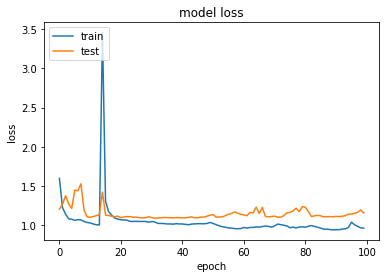

In [48]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The result looks like the model gets stable after 20 epochs

In [103]:
y_prediction = model.predict(X_test)

In [104]:
with open("../results/mfcc_100_fluency_regression.txt", "w") as output:
    for i in range(len(y_test)):
        result = "%s\t%d\t%f\n" % (wav_names[X_wav_test[i]], y_test[i], y_prediction[i][0])
        output.write(result)

### Train and Test the model with Mel-Spectrogram

In [85]:
X_mel = []
X_wav = []
Y = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)
    
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = melspec_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X_mel.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(Y))

(33300, 128, 259)
(11100,)


In [86]:
X_mel_train, X_mel_test, X_wav_train, X_wav_test, y_train, y_test = train_test_split(X_mel, X_wav, Y, test_size=0.3, random_state=42)

In [76]:
# reshape
X_mel_train = np.array(X_mel_train)
X_mel_test = np.array(X_mel_test)

# X_train = X_train.reshape(X_train.shape[0], max_time, num_mel, 1)
# X_test = X_test.reshape(X_test.shape[0], max_time, num_mel, 1)



print(np.shape(X_mel_train))
print(np.shape(X_mel_test))

(7770, 128, 259)
(3330, 128, 259)


In [77]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_melspec = np.shape(X_mel_train)[1]
max_time = np.shape(X_mel_train)[2]

In [78]:
input_shape = (num_melspec, max_time)

model_mel = Sequential()

model_mel.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_melspec, max_time)))
model_mel.add(Bidirectional(LSTM(512)))
model_mel.add(Dropout(drop_out_rate))
model_mel.add(Dense(num_dense_unit))
model_mel.add(Dense(128))
model_mel.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model_mel.compile(optimizer=adam, loss="mse", metrics=["mse"])

model_mel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_30 (Bidirectio (None, 128, 1024)         3162112   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 1024)              6295552   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 129       
Total params: 9,753,089
Trainable params: 9,753,089
Non-trainable params: 0
_________________________________________________________________


In [79]:
from datetime import datetime
logdir = "logs/scalars/melspec" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [80]:
num_epochs = 50
# model.load_weights('../data/RNN_model_100.h5')

history_mel = model_mel.fit(X_mel_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False, class_weight = None,
         verbose = 1, validation_data = (X_mel_test, y_test), callbacks=[tensorboard_callback])

model.save('../data/RNN_melspec_model_50.h5')

Train on 7770 samples, validate on 3330 samples
Epoch 1/50
7770/7770 [==============================] - 63s 8ms/step - loss: 2.3017 - mean_squared_error: 2.3017 - val_loss: 1.2723 - val_mean_squared_error: 1.2723
Epoch 2/50
7770/7770 [==============================] - 62s 8ms/step - loss: 1.2242 - mean_squared_error: 1.2242 - val_loss: 1.1948 - val_mean_squared_error: 1.1948
Epoch 3/50
7770/7770 [==============================] - 62s 8ms/step - loss: 1.2143 - mean_squared_error: 1.2143 - val_loss: 1.1743 - val_mean_squared_error: 1.1743
Epoch 4/50
7770/7770 [==============================] - 62s 8ms/step - loss: 1.1119 - mean_squared_error: 1.1119 - val_loss: 1.1616 - val_mean_squared_error: 1.1616
Epoch 5/50
7770/7770 [==============================] - 62s 8ms/step - loss: 1.1010 - mean_squared_error: 1.1010 - val_loss: 1.1575 - val_mean_squared_error: 1.1575
Epoch 6/50
7770/7770 [==============================] - 62s 8ms/step - loss: 1.0870 - mean_squared_error: 1.0870 - val_loss: 1.

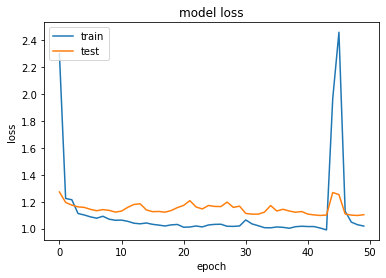

In [81]:
# summarize history for loss
plt.plot(history_mel.history['loss'])
plt.plot(history_mel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [83]:
y_mel_prediction = model_mel.predict(X_mel_test)

In [88]:
for i in range(10):
    print(wav_names[X_wav_test[i]], y_test[i], y_mel_prediction[i][0])

S22_They-All-Like.wav 2 2.6856332
S23_Gently-Place-Jims.wav 1 2.4612205
S03_Ralph-Prepared-Red.wav 4 4.7549405
S07_Too-Much-Curiosity.wav 5 4.0103807
S25_How-Oily-Do.wav 5 2.9591658
S04_Gregory-And-Tom.wav 3 2.5436985
S26_Try-To-Recall.wav 4 3.1693773
S19_She-Had-Your.wav 4 1.7288228
S07_Tradition-Requires-Parental.wav 4 3.7730925
S25_The-Tooth-Fairy.wav 3 2.9995189


In [90]:
with open("../results/mel_50_fluency_regression.txt", "w") as output:
    for i in range(len(y_test)):
        result = "%s\t%d\t%f\n" % (wav_names[X_wav_test[i]], y_test[i], y_mel_prediction[i][0])
        output.write(result)